In [1]:
import models_predictors
import unet_tf

import cv2
import matplotlib.pyplot as plt 
import numpy as np
from skimage.io import imread, imshow
import scipy.ndimage as ndi
import pandas as pd
import seaborn as sns  
import tensorflow as tf
import matplotlib.cm as cm         # Color map

Using TensorFlow backend.


In [2]:
YOLO_MODELS_PATH = "yolo_models/"
TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'

MASK_CATEGORIES = ['trophozoite','ring', 'schizont', 'gametocyte']
STR_MASK_CATEGORIES = '_'.join(MASK_CATEGORIES)

In [ ]:
# generate different colors for different classes 
with open(YOLO_MODELS_PATH+"obj_es.names", 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 4))

In [ ]:
COLORS = [[0,0,255],[100,255,51],[51,255,246]]

In [ ]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id]) + "  "+ str(confidence*100)+"%"

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, color, 5)
    
def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

In [3]:
train_ids = np.load(TRAIN_PATH+'malaria_train_transformed_256_256_names.npy',allow_pickle=True)
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy',allow_pickle=True)

In [4]:
X_train = np.load(TRAIN_PATH+'malaria_train_transformed_256_256.npy',allow_pickle=True)
Y_train =  np.load(TRAIN_PATH+'malaria_train_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)

In [5]:
X_test = np.load(TRAIN_PATH+'malaria_test_transformed_256_256.npy',allow_pickle=True)
Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy',allow_pickle=True)

In [113]:
model_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_1024_1024.cfg'
weigths_file = 'YOLOv2-malaria_20190818_trofozoito_esquizonte_gametocito_1024_1024_best.weights'

In [114]:
class_ids, confidences, boxes, images_index, masks = models_predictors.yolo_model_prediction(YOLO_MODELS_PATH, \
                                                                    "obj_es.names", model_file, weigths_file, \
                                                                    test_ids, 1024, 1024, conf_threshold = 0.4)

####### RESULTS ########
Total images tested: 120, Number of detections: 106


In [29]:
for i,pred in enumerate(class_ids):
    img_name = test_ids[images_index[i]][35:-4]
    left = boxes[i][0]
    top = boxes[i][1]
    rigth = left + boxes[i][1]
    bottom = top + boxes[i][3]
    #prediction_evaluation
    out = "{0} {1} {2} {3} {4} {5}".format(class_ids[i], confidences[i],round(left), round(top), round(rigth), round(bottom))
    f = open( "prediction_evaluation/" + img_name + '.txt', "a")
    if (images_index[i] == 2 ):
        print(img_name)
    f.write(out+ "\n")
    


c70894fa-50e8-4eed-a5a8-159a20153a49
c70894fa-50e8-4eed-a5a8-159a20153a49
c70894fa-50e8-4eed-a5a8-159a20153a49


In [85]:
model_file2 = 'YOLOv2-malaria_20191013_trofozoito_esquizonte_gametocito_1024_1024[artificial_data].cfg'
weigths_file2 = 'YOLOv2-malaria_20191013_trofozoito_esquizonte_gametocito_1024_1024[artificial_data]_best_F3.weights'

In [86]:
#class_ids2, confidences2, boxes2, images_index2, masks2 = models_predictors.yolo_model_prediction(YOLO_MODELS_PATH, \
class_ids, confidences, boxes, images_index, masks = models_predictors.yolo_model_prediction(YOLO_MODELS_PATH, \
                                                                                "obj_es.names", model_file2, \
                                                                                weigths_file2, test_ids, \
                                                                                1024, 1024, conf_threshold = 0.4)

####### RESULTS ########
Total images tested: 120, Number of detections: 30


In [115]:
masks_256_256 = []
for m in masks:
    new_mask = cv2.resize(m, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
    masks_256_256.append(np.expand_dims(new_mask, axis=2))

In [116]:
test_score, test_metrics= unet_tf.get_score(Y_test, masks_256_256)

/home/erick/Documents/bioinformatic_thesis_project/code/training/unet_tf.py:771: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)
/home/erick/anaconda3/envs/bioinformatic_thesis_gpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/erick/anaconda3/envs/bioinformatic_thesis_gpu/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erick/Documents/bioinformatic_thesis_project/code/training/unet_tf.py:793: RuntimeWarning: Mean of empty slice
  score = np.nanmean(summary[:,1]) # Final score.


In [117]:
print("avg_iou   :", np.nanmean(test_metrics[:,1]))
print("avg_prec   :", np.nanmean(test_metrics[:,1]))
print("avg_recall :",np.nanmean(test_metrics[:,2]))

avg_iou   : 0.6382488479262672
avg_prec   : 0.6382488479262672
avg_recall : 0.29992063492063487


In [118]:
tmp = np.concatenate([np.arange(len(test_index)).reshape(-1,1),
                      test_index.reshape(-1,1),
                      test_score.reshape(-1,1)], axis=1)
valid_score_df = pd.DataFrame(tmp, columns=(['index', 'test_index','valid_score']))
valid_score_df.describe()

,index,test_index,valid_score
count,120.000000,120.000000,62.000000
mean,59.500000,59.500000,0.638249
std,34.785054,34.785054,0.346265
min,0.000000,0.000000,0.000000
25%,29.750000,29.750000,0.297619
50%,59.500000,59.500000,0.714286
75%,89.250000,89.250000,1.000000
max,119.000000,119.000000,1.000000


In [119]:
len(boxes)

106

In [120]:
images_dict = {}
images_name = {}

for i,box in enumerate(boxes):
    im_id = images_index[i]
    im_name = test_ids[im_id]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    if im_id in images_dict:
        img = images_dict[im_id]
        draw_bounding_box(img, class_ids[i], round(confidences[i],2), round(x), round(y), round(x+w), round(y+h))
    
    else:
        img = cv2.imread(test_ids[im_id])
        draw_bounding_box(img, class_ids[i], round(confidences[i],2), round(x), round(y), round(x+w), round(y+h))
        images_dict[im_id] = img
        images_name[im_id] = im_name[35:-4]

In [121]:
for id, image in images_dict.items():
       
    # save output image to disk 
    cv2.imwrite("predictions_yolo/"+str(id) + "_yolo_pred.jpg", image)

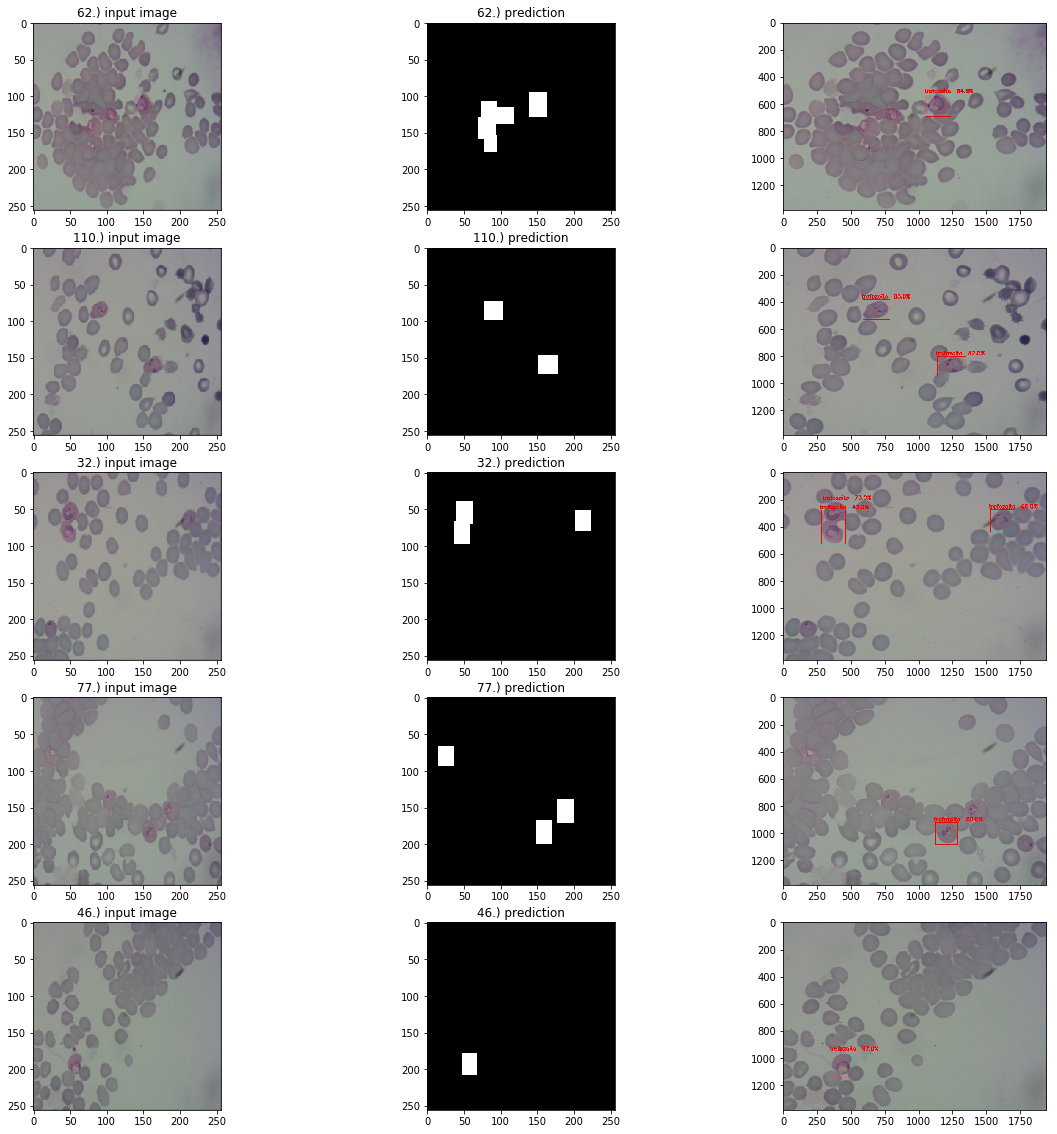

In [122]:
n = 5
fig, axs = plt.subplots(n,3,figsize=(20,20))
list_ = valid_score_df.sort_values(by='valid_score', ascending=False)[:n]['index'].values.astype(np.int)
#list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
for i,n in enumerate(list_):
    img, img_type = imshow_args(X_test[n])
    axs[i,0].imshow(img, img_type)
    axs[i,0].set_title('{}.) input image'.format(n))
    axs[i,1].imshow(Y_test[n,:,:,0], cm.gray)
    axs[i,1].set_title('{}.) true mask'.format(n))
    axs[i,2].imshow(imread( "predictions_yolo/"+str(n) + "_yolo_pred.jpg" )[:,:,:3])
    axs[i,1].set_title('{}.) prediction'.format(n))

In [16]:
nn_name = "u-net_models/unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte"

In [17]:
u_net = unet_tf.NeuralNetwork()
sess = u_net.load_session_from_file(nn_name, allow_growth=True, same_location=True)

/home/erick/Documents/bioinformatic_thesis_project/code/training/u-net_models/unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte.meta
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from u-net_models/unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte
u-net_models/unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte
u-net_models/unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte
Parameters of the loaded neural network
	nn_name = u-net_models/unet-malaria_256_256_201908200413_trophozoite_ring_schizont_gametocyte, epoch = 400.11, mb_size = 10
	input_shape = (256, 256, 3), output_shape = (256, 256, 1)
	learn_rate = 0.0000000000, learn_rate_0 = 0.0010000000, dropout_proba = 0.1
	learn_rate_step = 3, learn_rate_pos = 133, learn_rate_alpha = 0.25


In [18]:
#for op in sess.graph.get_operations():
#    if(op.type in ['Conv2D']):
#        print(op.name, op.inputs, op.outputs)

In [19]:
test_index = np.arange(0,test_ids.shape[0])

In [20]:
y_test_pred_proba = u_net.get_prediction(sess, X_test)
y_test_pred  = unet_tf.trsf_proba_to_binary(y_test_pred_proba)

In [21]:
test_score, test_metrics= unet_tf.get_score(Y_test, y_test_pred)

/home/erick/anaconda3/envs/bioinformatic_thesis_gpu/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/erick/anaconda3/envs/bioinformatic_thesis_gpu/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erick/Documents/bioinformatic_thesis_project/code/training/unet_tf.py:771: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp/(tp+fp)
/home/erick/Documents/bioinformatic_thesis_project/code/training/unet_tf.py:793: RuntimeWarning: Mean of empty slice
  score = np.nanmean(summary[:,1]) # Final score.


In [22]:
tmp = np.concatenate([np.arange(len(test_index)).reshape(-1,1),
                      test_index.reshape(-1,1),
                      test_score.reshape(-1,1)], axis=1)
valid_score_df = pd.DataFrame(tmp, columns=(['index', 'test_index','valid_score']))
valid_score_df.describe()

,index,test_index,valid_score
count,120.000000,120.000000,112.000000
mean,59.500000,59.500000,0.060400
std,34.785054,34.785054,0.092865
min,0.000000,0.000000,0.000000
25%,29.750000,29.750000,0.000000
50%,59.500000,59.500000,0.007937
75%,89.250000,89.250000,0.077381
max,119.000000,119.000000,0.428571


In [23]:
print("avg_prec   :", np.nanmean(test_metrics[:,1]))
print("avg_recall :",np.nanmean(test_metrics[:,2]))

avg_prec   : 0.0604004697116942
avg_recall : 0.07459467120181404


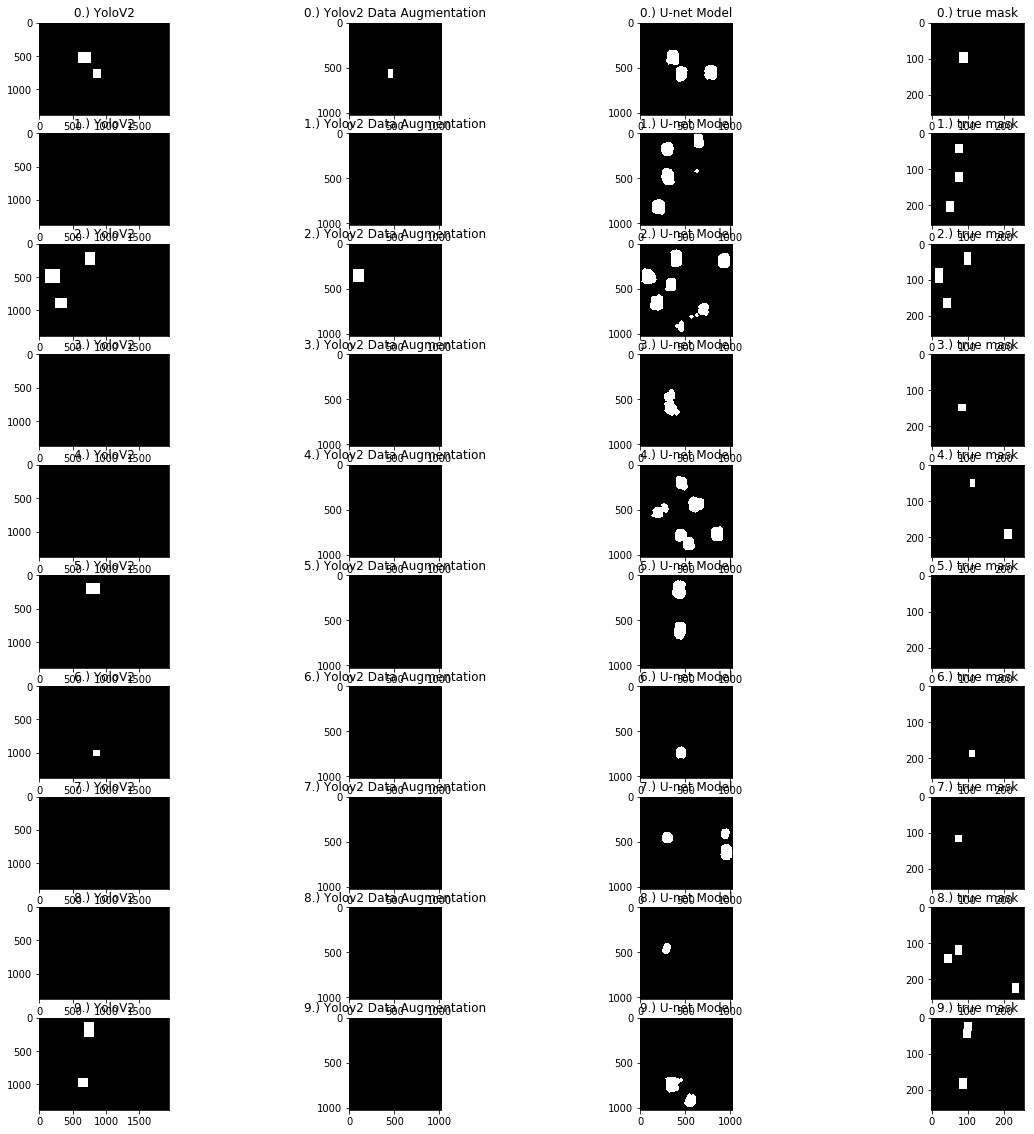

In [24]:
fig, axes = plt.subplots(10,4,figsize=(20,20))


for img_id, mask in enumerate(masks[:10]):
    IMG_HEIGHT = 1024
    IMG_WIDTH = 1024
    mask_model1 = mask
    mask_model2 = cv2.resize(masks2[img_id], dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
    mask_model3 = cv2.resize(np.squeeze(y_test_pred[img_id]), dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)


    axes[img_id,0].imshow(mask, cmap='gray')
    axes[img_id,0].set_title('{}.) YoloV2'.format(img_id))
    
    axes[img_id,1].imshow(mask_model2, cmap='gray')
    axes[img_id,1].set_title('{}.) Yolov2 Data Augmentation'.format(img_id))
    
    axes[img_id,2].imshow(mask_model3, cmap='gray')
    axes[img_id,2].set_title('{}.) U-net Model'.format(img_id))
    
    axes[img_id,3].imshow(np.squeeze(Y_test[img_id]), cmap='gray')
    axes[img_id,3].set_title('{}.) true mask'.format(img_id))

In [21]:
np.zeros((2, 3), dtype=np.uint8)

array([[0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [34]:
data =np.array([[71,213],[302,53336]])
data

array([[   71,   213],
       [  302, 53336]])

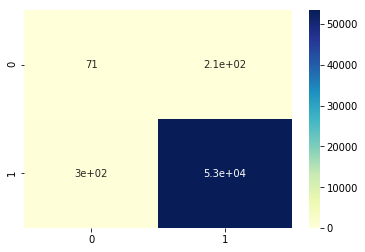

In [38]:
sns.heatmap(data,annot=True, cmap = "YlGnBu")